In [5]:
import gzip
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from PIL import Image
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

In [6]:
# open the gzip files
train = gzip.open('train-images-idx3-ubyte.gz', 'rb')
train_label = gzip.open('train-labels-idx1-ubyte.gz', 'rb')
test = gzip.open('t10k-images-idx3-ubyte.gz', 'rb')
test_label = gzip.open('t10k-labels-idx1-ubyte.gz', 'rb')

# reading bytes from the gzip files
train.read(16)
train_label.read(8)
test.read(16)
test_label.read(8)


# load image data and reshape
train_image_data = np.frombuffer(train.read(), dtype=np.uint8).reshape(-1, 28, 28)
train_label_data = np.frombuffer(train_label.read(), dtype=np.uint8)

test_image_data = np.frombuffer(test.read(), dtype=np.uint8).reshape(-1, 28, 28)
test_label_data = np.frombuffer(test_label.read(), dtype=np.uint8)

# Ensure train_image_data and train_label_data have compatible shapes
train_image_data = train_image_data[:len(train_label_data)]

# train-validation split(80-20 split)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_image_data, train_label_data, test_size=0.2, random_state=42
)

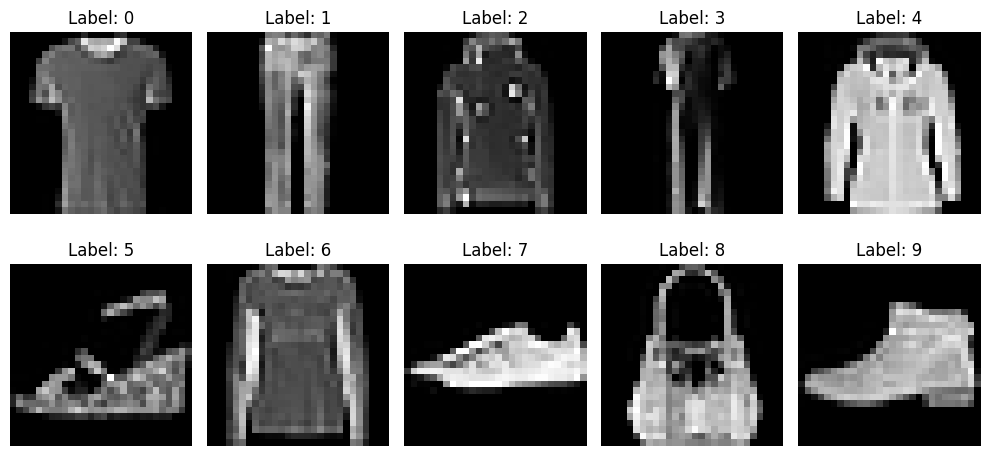

In [7]:
# Visualize all 10 unique labels
plt.figure(figsize=(10, 5))
for i in range(10):
    index = np.where(train_labels == i)[0][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(train_images[index], cmap='gray')
    plt.title(f'Label: {i}')
    plt.axis('off')
plt.tight_layout()
plt.show()

0 : 'T-shirt'
1 : 'Trouser',
2 : 'Pullover',
3 : 'Dress',
4 : 'Coat',
5 : 'Sandal',
6 : 'Shirt',
7 : 'Sneaker',
8 : 'Bag',
9 : 'Ankle Boot'

In [8]:
# This is for Exploratory Data Analysis

# Flatten the images
train_images_flat = train_image_data.reshape(train_image_data.shape[0], -1)
test_images_flat = test_image_data.reshape(test_image_data.shape[0], -1)

# Create DataFrames
train_df = pd.DataFrame(train_images_flat)
train_df['label'] = train_label_data

test_df = pd.DataFrame(test_images_flat)
test_df['label'] = test_label_data

print(train_df.shape)
print(test_df.shape)

(60000, 785)
(10000, 785)


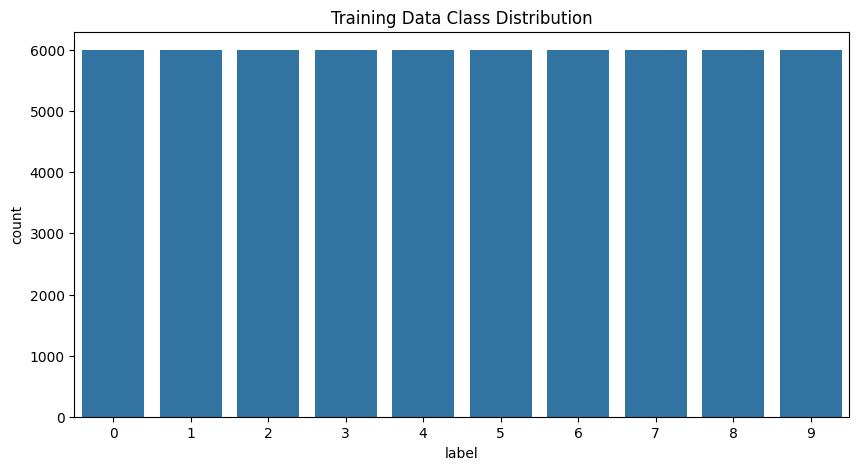

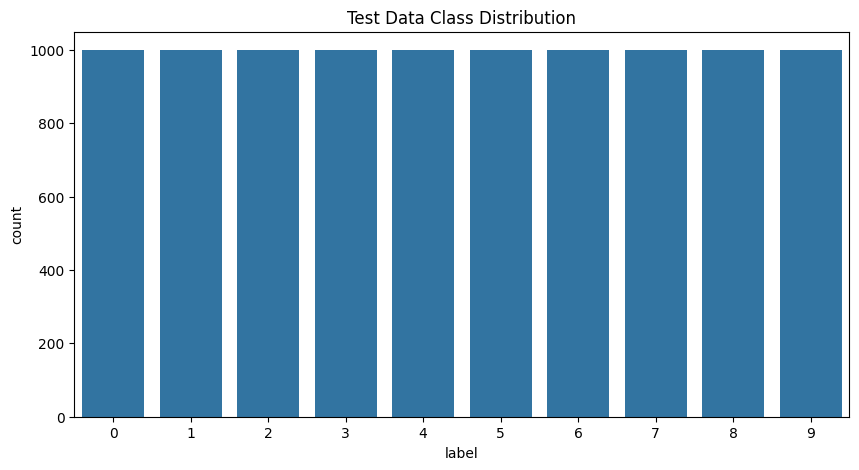

In [9]:
# Visualize class distribution in training data
plt.figure(figsize=(10, 5))
sns.countplot(x=train_df['label'])
plt.title('Training Data Class Distribution')
plt.show()

# Visualize class distribution in test data
plt.figure(figsize=(10, 5))
sns.countplot(x=test_df['label'])
plt.title('Test Data Class Distribution')
plt.show()

In [10]:
# check if data has any nan values (Data Cleaning)
print(np.isnan(train_images).any())
print(np.isnan(val_images).any())
print(np.isnan(test_image_data).any())

False
False
False


In [11]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_val_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images.numpy().astype(np.uint8)
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Convert data to PyTorch tensors
train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)  
val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.long)
test_image_data = torch.tensor(test_image_data, dtype=torch.float32)
test_label_data = torch.tensor(test_label_data, dtype=torch.long)

# Create custom datasets with transforms (Data transformation)
train_dataset = CustomDataset(train_images, train_labels, transform=transform_train)
val_dataset = CustomDataset(val_images, val_labels, transform=transform_val_test)
test_dataset = CustomDataset(test_image_data, test_label_data, transform=transform_val_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
# PCA for dimensionality reduction
pca = PCA(n_components=40)
train_images_pca = pca.fit_transform(train_images_flat)
test_images_pca = pca.transform(test_images_flat)
print(pca.explained_variance_ratio_.sum())

0.8449987422132577


We got a variance of 85% with 40 PCA components. For PCA a higher variance allows us to distinguish classes better.

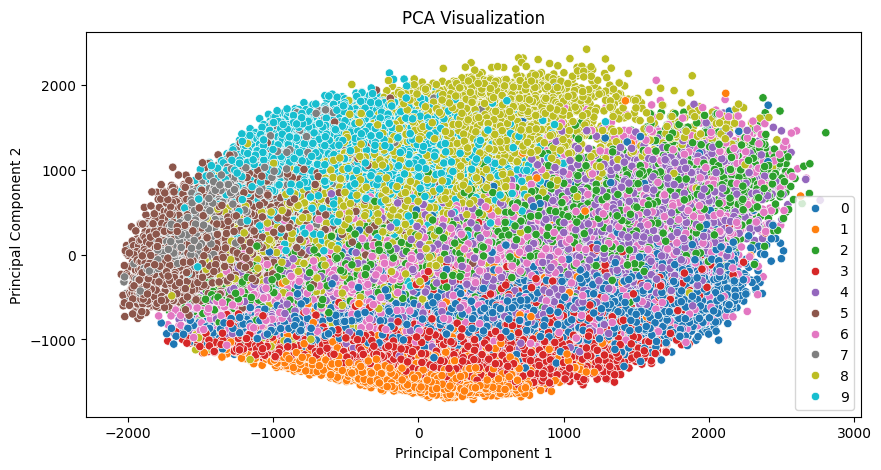

In [13]:
# PCA plotting
plt.figure(figsize=(10, 5))
sns.scatterplot(x=train_images_pca[:, 0], y=train_images_pca[:, 1], hue=train_label_data, palette='tab10')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [14]:
# Decision Tree Classifier

dt = DecisionTreeClassifier()
dt.fit(train_images_pca, train_label_data)
predictions = dt.predict(test_images_pca)
accuracy = accuracy_score(test_label_data, predictions)
print(f'Decision Tree Classifier Accuracy: {accuracy * 100:.2f}%')

Decision Tree Classifier Accuracy: 76.71%


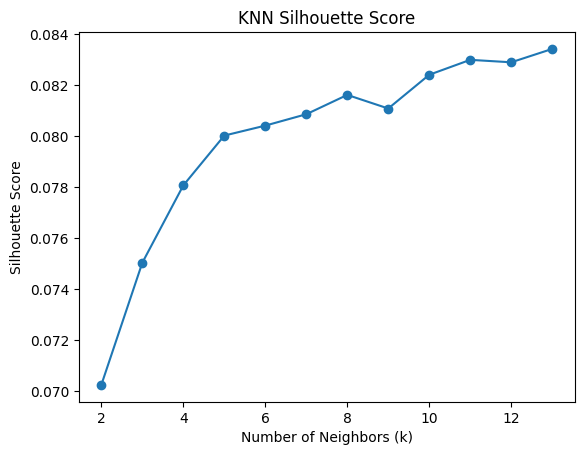

In [15]:
# find best k
silhouette_scores = []
for k in range(2, 14):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_images_pca, train_label_data)
    predictions = knn.predict(test_images_pca)
    silhouette_scores.append(silhouette_score(test_images_pca, predictions))

plt.plot(range(2, 14), silhouette_scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Silhouette Score')
plt.title('KNN Silhouette Score')
plt.show()


Using the elbow method we will pick 5 as the optimal k for KNN.

In [16]:
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(train_images_pca, train_label_data)
predictions = knn.predict(test_images_pca)
accuracy = accuracy_score(test_label_data, predictions)
print(f'KNN Classifier Accuracy: {accuracy * 100:.2f}%')

KNN Classifier Accuracy: 85.37%


In [2]:
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Open the gzip files
train = gzip.open('train-images-idx3-ubyte.gz', 'rb')
train_label = gzip.open('train-labels-idx1-ubyte.gz', 'rb')
test = gzip.open('t10k-images-idx3-ubyte.gz', 'rb')
test_label = gzip.open('t10k-labels-idx1-ubyte.gz', 'rb')

# Load the data from the gzip files
train.read(16)  # Skip the header
X_train_full = np.frombuffer(train.read(), dtype=np.uint8).reshape(-1, 28, 28)

train_label.read(8)  # Skip the header
y_train_full = np.frombuffer(train_label.read(), dtype=np.uint8)

test.read(16)  # Skip the header
X_test = np.frombuffer(test.read(), dtype=np.uint8).reshape(-1, 28, 28)

test_label.read(8)  # Skip the header
y_test = np.frombuffer(test_label.read(), dtype=np.uint8)

# Normalize pixel values to be between 0 and 1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Flatten the images for compatibility with traditional ML models
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Split the training set into a smaller training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))



Decision Tree Accuracy: 0.7894


In [17]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(64 * 6 * 6, 512)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(-1, 64 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = CNN()
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
for epoch in range(32):
    model.train()
    for images, labels in train_loader:
        images = images.float()
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.float()
            output = model(images)
            val_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)

    print('Epoch: {} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.2f}%'.format(epoch + 1, val_loss, 100. * correct / len(val_loader.dataset)))

Epoch: 1 	Validation Loss: 0.006499 	Validation Accuracy: 85.03%
Epoch: 2 	Validation Loss: 0.005366 	Validation Accuracy: 87.03%
Epoch: 3 	Validation Loss: 0.004856 	Validation Accuracy: 88.50%
Epoch: 4 	Validation Loss: 0.004622 	Validation Accuracy: 89.09%
Epoch: 5 	Validation Loss: 0.004414 	Validation Accuracy: 89.57%
Epoch: 6 	Validation Loss: 0.004490 	Validation Accuracy: 89.22%
Epoch: 7 	Validation Loss: 0.004262 	Validation Accuracy: 89.78%
Epoch: 8 	Validation Loss: 0.004080 	Validation Accuracy: 90.18%
Epoch: 9 	Validation Loss: 0.004081 	Validation Accuracy: 90.68%
Epoch: 10 	Validation Loss: 0.003818 	Validation Accuracy: 90.92%
Epoch: 11 	Validation Loss: 0.003782 	Validation Accuracy: 90.87%
Epoch: 12 	Validation Loss: 0.003795 	Validation Accuracy: 90.99%
Epoch: 13 	Validation Loss: 0.003686 	Validation Accuracy: 91.59%
Epoch: 14 	Validation Loss: 0.003736 	Validation Accuracy: 91.30%
Epoch: 15 	Validation Loss: 0.003669 	Validation Accuracy: 91.48%
Epoch: 16 	Validati

In [20]:
# Test the model
model = CNN()
model.load_state_dict(torch.load('model.pth'))
model.eval()

test_loss = 0
correct = 0
predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.float()
        output = model(images)
        test_loss += criterion(output, labels).item()
        pred = output.argmax(dim=1, keepdim=True)
        predictions.extend(pred)
        correct += pred.eq(labels.view_as(pred)).sum().item()
test_loss /= len(test_loader.dataset)

print('Test Loss: {:.6f} \tTest Accuracy: {:.2f}%'.format(test_loss, 100. * correct / len(test_loader.dataset)))

C:\Users\arian\AppData\Local\Temp\ipykernel_19664\1057103974.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


Test Loss: 0.003572 	Test Accuracy: 91.60%


              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.90      0.85      0.88      1000
           3       0.92      0.91      0.92      1000
           4       0.83      0.90      0.87      1000
           5       0.99      0.98      0.98      1000
           6       0.73      0.79      0.76      1000
           7       0.95      0.96      0.96      1000
           8       0.99      0.98      0.98      1000
           9       0.96      0.97      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

F1 Score: 0.92
Precision: 0.92
Recall: 0.92


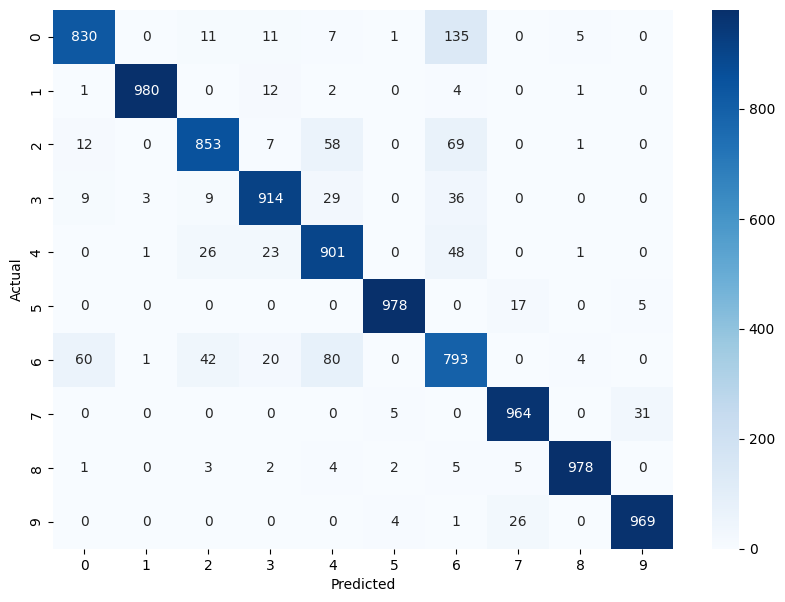

In [21]:
# Classification Report
predictions = torch.cat(predictions, dim=0)
print(classification_report(test_label_data, predictions, target_names=[str(i) for i in range(10)]))

# Confusion Matrix
cm = confusion_matrix(test_label_data, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.xlabel('Predicted')
plt.ylabel('Actual')

# F1 Score
f1 = f1_score(test_label_data, predictions, average='macro')
print(f'F1 Score: {f1:.2f}')

# Precision
precision = precision_score(test_label_data, predictions, average='macro')
print(f'Precision: {precision:.2f}')

# Recall
recall = recall_score(test_label_data, predictions, average='macro')
print(f'Recall: {recall:.2f}')

plt.show()

In [ ]:
import gzip
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# Open the gzip files
train = gzip.open('train-images-idx3-ubyte.gz', 'rb')
train_label = gzip.open('train-labels-idx1-ubyte.gz', 'rb')
test = gzip.open('t10k-images-idx3-ubyte.gz', 'rb')
test_label = gzip.open('t10k-labels-idx1-ubyte.gz', 'rb')

# Load the data from the gzip files
train.read(16)  # Skip the header
X_train_full = np.frombuffer(train.read(), dtype=np.uint8).reshape(-1, 28, 28)

train_label.read(8)  # Skip the header
y_train_full = np.frombuffer(train_label.read(), dtype=np.uint8)

test.read(16)  # Skip the header
X_test = np.frombuffer(test.read(), dtype=np.uint8).reshape(-1, 28, 28)

test_label.read(8)  # Skip the header
y_test = np.frombuffer(test_label.read(), dtype=np.uint8)

# Close the files
train.close()
train_label.close()
test.close()
test_label.close()

# Normalize pixel values to be between 0 and 1
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

# Flatten the images for compatibility with ANN models
X_train_full = X_train_full.reshape(X_train_full.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Split the training set into a smaller training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Convert labels to categorical for ANN
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

# Define a function to create an ANN model
def create_ann_model(hidden_units=128, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=784, activation=activation))
    model.add(Dense(hidden_units, activation=activation))
    model.add(Dense(10, activation='softmax'))  # 10 output classes for Fashion MNIST
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Manual hyperparameter tuning
hyperparameters = {
    'hidden_units': [64, 128],
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam', 'sgd'],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

best_model = None
best_accuracy = 0
best_params = {}

for hidden_units in hyperparameters['hidden_units']:
    for activation in hyperparameters['activation']:
        for optimizer in hyperparameters['optimizer']:
            for batch_size in hyperparameters['batch_size']:
                for epochs in hyperparameters['epochs']:
                    print(f"Training with: hidden_units={hidden_units}, activation={activation}, "
                          f"optimizer={optimizer}, batch_size={batch_size}, epochs={epochs}")
                    
                    # Create and train the model
                    model = create_ann_model(hidden_units, activation, optimizer)
                    history = model.fit(X_train, y_train_cat, 
                                        validation_data=(X_val, y_val_cat),
                                        batch_size=batch_size, epochs=epochs, verbose=0)
                    
                    # Evaluate on validation set
                    val_accuracy = history.history['val_accuracy'][-1]
                    print(f"Validation Accuracy: {val_accuracy}")
                    
                    # Check if this is the best model
                    if val_accuracy > best_accuracy:
                        best_accuracy = val_accuracy
                        best_model = model
                        best_params = {
                            'hidden_units': hidden_units,
                            'activation': activation,
                            'optimizer': optimizer,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)
print("Best Validation Accuracy:", best_accuracy)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Metrics
print("F1 Score:", f1_score(y_test, y_pred_labels, average='weighted'))
print("Precision:", precision_score(y_test, y_pred_labels, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_labels, average='weighted'))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_labels))
print("Classification Report:\n", classification_report(y_test, y_pred_labels))


Training with: hidden_units=64, activation=relu, optimizer=adam, batch_size=32, epochs=10


C:\Users\arian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.8853333592414856
Training with: hidden_units=64, activation=relu, optimizer=adam, batch_size=32, epochs=20
Validation Accuracy: 0.8834999799728394
Training with: hidden_units=64, activation=relu, optimizer=adam, batch_size=64, epochs=10
Validation Accuracy: 0.8842499852180481
Training with: hidden_units=64, activation=relu, optimizer=adam, batch_size=64, epochs=20
Validation Accuracy: 0.8841666579246521
Training with: hidden_units=64, activation=relu, optimizer=sgd, batch_size=32, epochs=10
Validation Accuracy: 0.8793333172798157
Training with: hidden_units=64, activation=relu, optimizer=sgd, batch_size=32, epochs=20
Validation Accuracy: 0.8845000267028809
Training with: hidden_units=64, activation=relu, optimizer=sgd, batch_size=64, epochs=10
Validation Accuracy: 0.8759166598320007
Training with: hidden_units=64, activation=relu, optimizer=sgd, batch_size=64, epochs=20
Validation Accuracy: 0.8830833435058594
Training with: hidden_units=64, activation=tanh, optim

Sources:
https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
https://stackoverflow.com/questions/12067446/how-many-principal-components-to-take